#Enviroment Initialization 

In [ ]:
import tensorflow as tf
import cv2, os, re
import pathlib, json
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import pickle, math

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from google.colab import output
!pip install tensorflow-addons
import tensorflow_addons as tfa

import matplotlib.pyplot as plt 

!nvidia-smi

Thu Mar 24 15:01:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/MyDrive/Datasets/'

Macroscopic_aug.zip   Macroscopic.zip  PKLOT-WEIGHTS  training
Macroscopic_Training  PKLot.tar.gz     SegTHOR_data


In [ ]:
path = '/gdrive/MyDrive/Datasets/PKLOT/PKLot.tar.gz'

!tar -zxf $path 'PKLot/*.txt' 

^C


#Parameters and Auxiliary Functions

In [ ]:
#TRAIN_PKLOTS = ['UFPR05','UFPR04','PUCPR']
TRAIN_PKLOTS = ['UFPR04','UFPR05','PUCPR']
TARGET_PKLOTS = ['UFPR04','UFPR05','PUCPR']
ANN_TYPES = ['Poly','Bbox','Centroid']
#ANN_TYPES = ['Poly']
IMG_SIZE = (32,32)
BUFFER_SIZE=32*20 #datagenerator buffer (I/0)
BATCH_SIZE=32 #cnn batch
EPOCHS=20
EPOCHS_FT=5

In [ ]:

def load_image(image_path,do_aug=False):
    
    image = tf.io.read_file(image_path)  
    image = tf.image.decode_jpeg(image)

    #AUG @andre
    if do_aug and image.shape[0] is not None:    
      #image = tf.image.random_brightness(image, max_delta=0.2)
      image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
      image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
      image = tf.image.random_hue(image, max_delta=0.5)      
      image = tf.image.random_flip_left_right(image, seed=None)
      image = tf.image.random_flip_up_down(image, seed=None)   

      image = tf.keras.preprocessing.image.random_shift(image,0.2,0.2, fill_mode='wrap',channel_axis=0)    
      
      image = tf.keras.preprocessing.image.random_zoom(image, [0.8,0.8], fill_mode='wrap')

      
    
    image = tf.image.resize(image, IMG_SIZE,
                            method=tf.image.ResizeMethod.BILINEAR)
    

    
    
    image = tf.cast(image, tf.float32)/255.
    
    label = tf.strings.split(image_path, '/')[5]
    
    label = tf.cast(tf.equal(label, b'Occupied'), tf.int32)

    return image,label

In [ ]:
list_of_files = 'PKLot/list-' + 'UFPR04' + '-' + 'Poly' + '.txt'
!shuf $list_of_files | head -n 1

PKLot/UFPR04/Sunny/2012-12-12/Poly/Occupied/PKLot-UFPR04-Sunny-2012-12-12-Poly-Occupied-2012-12-12_15_30_11-Slot_ID19.jpg


PKLot/UFPR04/Cloudy/2013-01-22/Poly/Occupied/PKLot-UFPR04-Cloudy-2013-01-22-Poly-Occupied-2013-01-22_19_35_14-Slot_ID1.jpg


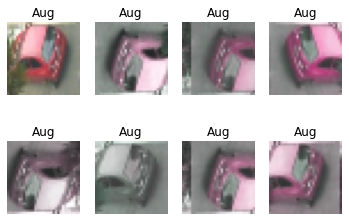

In [ ]:
image_path=!shuf '$list_of_files' | head -n 1

#image_path = image_path[0]
image_path = 'PKLot/UFPR04/Cloudy/2013-01-22/Poly/Occupied/PKLot-UFPR04-Cloudy-2013-01-22-Poly-Occupied-2013-01-22_19_35_14-Slot_ID1.jpg'

print(image_path)
for i in range(8):      
      ax = plt.subplot(2, 4, i + 1)   
      if i==0: 
        im = load_image(image_path,False)
      else:
        im = load_image(image_path,True)
      
      
      im = tf.keras.utils.img_to_array(im[0])
      
      plt.imshow(im)  
      
      plt.title('Aug')
      plt.axis("off")


In [ ]:
def plot_stats(stats,plot_title,figsize=(10,6),save_path=None):
  columns = list(zip(*stats))

  
  x = np.arange(len(columns[0]))  # the label locations
  width = 0.35  # the width of the bars
  hline = np.minimum(columns[1],columns[2])
  

  fig, ax = plt.subplots(figsize=figsize)

  ax.hlines(hline, x - width, x + width , colors='r', linestyles='dashed', linewidth=5, label='Normalization')

  rects1 = ax.bar(x - width/2, columns[2], width, label=' Occupied')
  rects2 = ax.bar(x + width/2, columns[1], width, label=' Empty')
  
    
  
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Samples')
  ax.set_title(plot_title)
  ax.set_xticks(x)
  ax.set_xticklabels(columns[0])
  ax.legend()


  fig.tight_layout()
  if save_path is not None:
    plt.savefig(save_path)

  #plt.show()

  

In [ ]:
class PKLOT_NET(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()

        self.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
        self.add(Flatten())
        self.add(Dense(64, activation='relu'))        
        self.add(Dense(nb_classes, activation='softmax'))     

    
    



  

In [ ]:
augment = False

for PKLOT_NAME in TRAIN_PKLOTS:
    for ANN_TYPE in ['Bbox']:

      if augment:
        compl = '-with-aug'
      else:
        compl = '-without-aug'

      workingdir = PKLOT_NAME + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + compl
      print(workingdir)    
      pathlib.Path(workingdir).mkdir(parents=True, exist_ok=True)

      list_of_files = 'PKLot/list-' + PKLOT_NAME + '-' + ANN_TYPE + '.txt'
      
      #!sed -i '/txt/d'  $list_of_files 
      #!sed -i '/list/d'  $list_of_files 
      #!sed -i '$ d' $list_of_files
      
      #Convert path to colab
      #!sed -i 's/\/home\/aghochuli\/Datasets\/PKLot\///g' $list_of_files

      with open(list_of_files,'r') as myfile:
              files = myfile.read().splitlines()

      data = []
      
      for fname in files:       

          date = re.findall('\d\d\d\d-\d\d-\d\d',fname)
          
          if fname.find('Empty') > 0:
              cls = 0                 
          else:
              cls = 1        
              

          data.append([date[0],cls,fname])     
      
      df = pd.DataFrame(data, columns = ['DATE', 'CLASS', 'PATH'])
      df = df.sample(frac=1).reset_index(drop=True)

      pklot = df
      dates = pd.unique(pklot['DATE'])
      dates = np.sort(dates)
      stats = []
      #print('Data Range: ', dates)
      split = int(dates.shape[0]*.5)
      train = dates[split:]
      test = dates[:split]

      split = int(train.shape[0]*.6)
      val = train[split:]
      train = train[:split]

      batches = []
      for dates,batch_name in zip([train,val,test],['train','val','test']):

          date_df = pklot.loc[pklot['DATE'].between(dates[0],dates[-1])]    
          date_df = date_df.sample(frac=1).reset_index(drop=True)
          n_occupied = date_df.loc[date_df['CLASS'] == 1]    
          n_empty = date_df.loc[date_df['CLASS'] == 0]
        
          diff = n_empty.shape[0] - n_occupied.shape[0] 

          if(diff > 0):
            drop_indices = np.random.choice(n_empty.index, diff, replace=False)
          else: #Occupied  
            diff *= -1
            drop_indices = np.random.choice(n_occupied.index, diff, replace=False)

          
          df_subset = date_df.drop(drop_indices)       
          
          batches.append(df_subset['PATH'].to_list())  
          
          occupied = date_df['CLASS'] == 1    
          n_empty,n_occupied = np.unique(occupied,return_counts=True)[1]
          stats.append([batch_name,n_empty,n_occupied])  
          print('Number of Normalized Samples to ', batch_name,' : ', len(batches[-1]))

      for batch, step in zip(batches,['train','val','test']):
        path = '-'.join([PKLOT_NAME,ANN_TYPE,step,'.txt'])
        print(path)
        f = open(path, "w")
        for fname in batch:
          f.write(fname + '\n')
        f.close()
      title = PKLOT_NAME + ' samples per batch'

      #fig_path = workingdir + '/' + workingdir + '-protocol.jpg'
      print(stats)

      #plot_stats(stats,title,figsize=(8,6),save_path = fig_path)

v2-UFPR04-Bbox-32x32-without-aug


OSError: ignored

In [ ]:
for pklot in ['UFPR04','UFPR05','PUCPR']:
  for step in ['train','val','test']:
    !echo $pklot $step && cat $pklot-Bbox-$step*.txt | wc -l


#Holdout Training (30-20-50)


UFPR05-Poly-32x32-with-aug
Data Range:  ['2013-02-22' '2013-02-23' '2013-02-24' '2013-02-26' '2013-02-28'
 '2013-03-01' '2013-03-02' '2013-03-03' '2013-03-05' '2013-03-06'
 '2013-03-09' '2013-03-10' '2013-03-11' '2013-03-12' '2013-03-13'
 '2013-03-14' '2013-03-15' '2013-03-16' '2013-03-17' '2013-03-18'
 '2013-03-19' '2013-03-20' '2013-03-21' '2013-03-22' '2013-04-08'
 '2013-04-09' '2013-04-10' '2013-04-11' '2013-04-12' '2013-04-13'
 '2013-04-14' '2013-04-15' '2013-14-16']
Number of Normalized Samples to  train  :  29852
Number of Normalized Samples to  val  :  28580
Number of Normalized Samples to  test  :  78122


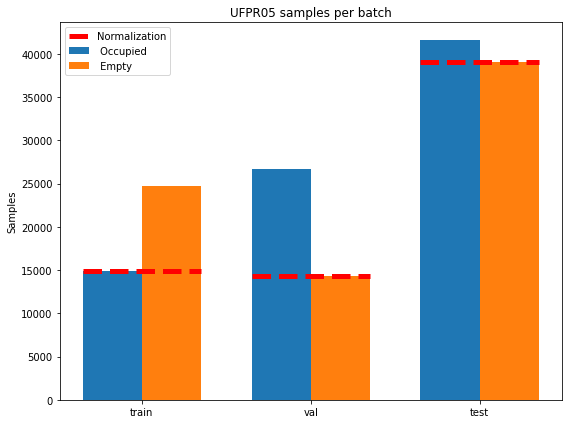

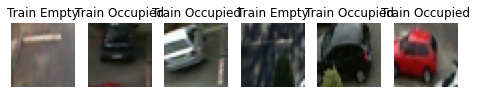

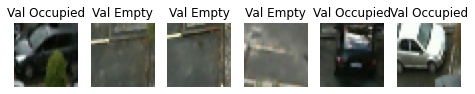

Epoch 1/20
933/933 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9508
Epoch 00001: val_loss improved from inf to 0.05910, saving model to UFPR05-Poly-32x32-with-aug/UFPR05-Poly-32x32-with-aug-checkpoint
933/933 [==============================] - 17s 18ms/step - loss: 0.1748 - accuracy: 0.9508 - val_loss: 0.0591 - val_accuracy: 0.9830
Epoch 2/20
922/933 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9867
Epoch 00002: val_loss improved from 0.05910 to 0.03732, saving model to UFPR05-Poly-32x32-with-aug/UFPR05-Poly-32x32-with-aug-checkpoint
933/933 [==============================] - 14s 15ms/step - loss: 0.0402 - accuracy: 0.9868 - val_loss: 0.0373 - val_accuracy: 0.9845
Epoch 3/20
922/933 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9911
Epoch 00003: val_loss improved from 0.03732 to 0.03181, saving model to UFPR05-Poly-32x32-with-aug/UFPR05-Poly-32x32-with-aug-checkpoint
933/933 [==============================

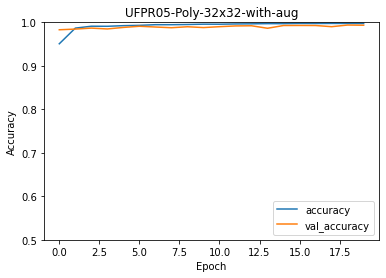

UFPR05-Bbox-32x32-with-aug
Data Range:  ['2013-02-22' '2013-02-23' '2013-02-24' '2013-02-26' '2013-02-28'
 '2013-03-01' '2013-03-02' '2013-03-03' '2013-03-05' '2013-03-06'
 '2013-03-09' '2013-03-10' '2013-03-11' '2013-03-12' '2013-03-13'
 '2013-03-14' '2013-03-15' '2013-03-16' '2013-03-17' '2013-03-18'
 '2013-03-19' '2013-03-20' '2013-03-21' '2013-03-22' '2013-04-08'
 '2013-04-09' '2013-04-10' '2013-04-11' '2013-04-12' '2013-04-13'
 '2013-04-14' '2013-04-15' '2013-14-16']
Number of Normalized Samples to  train  :  29852
Number of Normalized Samples to  val  :  28580
Number of Normalized Samples to  test  :  78122


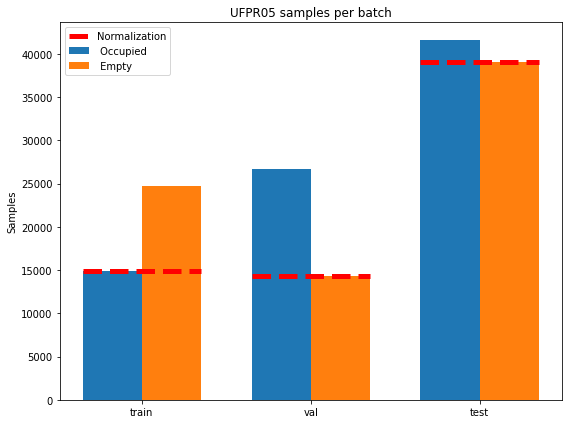

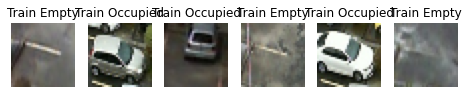

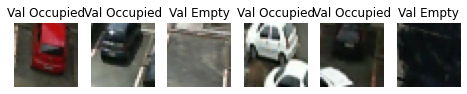

Epoch 1/20
925/933 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9507
Epoch 00001: val_loss improved from inf to 0.06616, saving model to UFPR05-Bbox-32x32-with-aug/UFPR05-Bbox-32x32-with-aug-checkpoint
933/933 [==============================] - 17s 18ms/step - loss: 0.1816 - accuracy: 0.9509 - val_loss: 0.0662 - val_accuracy: 0.9813
Epoch 2/20
922/933 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9880
Epoch 00002: val_loss improved from 0.06616 to 0.03571, saving model to UFPR05-Bbox-32x32-with-aug/UFPR05-Bbox-32x32-with-aug-checkpoint
933/933 [==============================] - 14s 15ms/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.0357 - val_accuracy: 0.9855
Epoch 3/20
926/933 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9921
Epoch 00003: val_loss improved from 0.03571 to 0.03351, saving model to UFPR05-Bbox-32x32-with-aug/UFPR05-Bbox-32x32-with-aug-checkpoint
933/933 [==============================

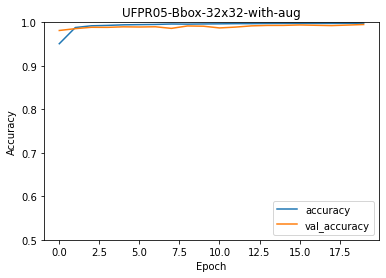

UFPR05-Centroid-32x32-with-aug
Data Range:  ['2013-02-22' '2013-02-23' '2013-02-24' '2013-02-26' '2013-02-28'
 '2013-03-01' '2013-03-02' '2013-03-03' '2013-03-05' '2013-03-06'
 '2013-03-09' '2013-03-10' '2013-03-11' '2013-03-12' '2013-03-13'
 '2013-03-14' '2013-03-15' '2013-03-16' '2013-03-17' '2013-03-18'
 '2013-03-19' '2013-03-20' '2013-03-21' '2013-03-22' '2013-04-08'
 '2013-04-09' '2013-04-10' '2013-04-11' '2013-04-12' '2013-04-13'
 '2013-04-14' '2013-04-15' '2013-14-16']
Number of Normalized Samples to  train  :  29852
Number of Normalized Samples to  val  :  28580
Number of Normalized Samples to  test  :  78122


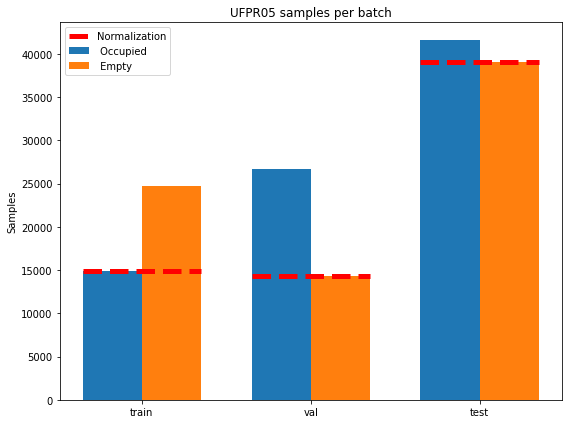

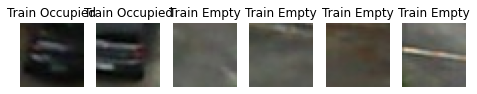

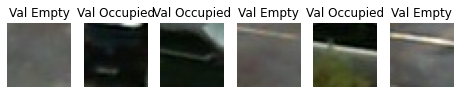

Epoch 1/20
930/933 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9440
Epoch 00001: val_loss improved from inf to 0.06566, saving model to UFPR05-Centroid-32x32-with-aug/UFPR05-Centroid-32x32-with-aug-checkpoint
933/933 [==============================] - 17s 17ms/step - loss: 0.2105 - accuracy: 0.9441 - val_loss: 0.0657 - val_accuracy: 0.9733
Epoch 2/20
924/933 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9828
Epoch 00002: val_loss did not improve from 0.06566
933/933 [==============================] - 13s 14ms/step - loss: 0.0531 - accuracy: 0.9829 - val_loss: 0.0738 - val_accuracy: 0.9686
Epoch 3/20
923/933 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9863
Epoch 00003: val_loss improved from 0.06566 to 0.06280, saving model to UFPR05-Centroid-32x32-with-aug/UFPR05-Centroid-32x32-with-aug-checkpoint
933/933 [==============================] - 12s 13ms/step - loss: 0.0430 - accuracy: 0.9863 - val_loss: 0.0628

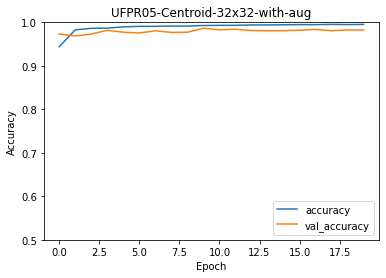

UFPR05-Patches-32x32-with-aug
Data Range:  ['2013-02-22' '2013-02-23' '2013-02-24' '2013-02-26' '2013-02-28'
 '2013-03-01' '2013-03-02' '2013-03-03' '2013-03-05' '2013-03-06'
 '2013-03-09' '2013-03-10' '2013-03-11' '2013-03-12' '2013-03-13'
 '2013-03-14' '2013-03-15' '2013-03-16' '2013-03-17' '2013-03-18'
 '2013-03-19' '2013-03-20' '2013-03-21' '2013-03-22' '2013-04-08'
 '2013-04-09' '2013-04-10' '2013-04-11' '2013-04-12' '2013-04-13'
 '2013-04-14' '2013-04-15' '2013-14-16']
Number of Normalized Samples to  train  :  149260
Number of Normalized Samples to  val  :  142900
Number of Normalized Samples to  test  :  390610


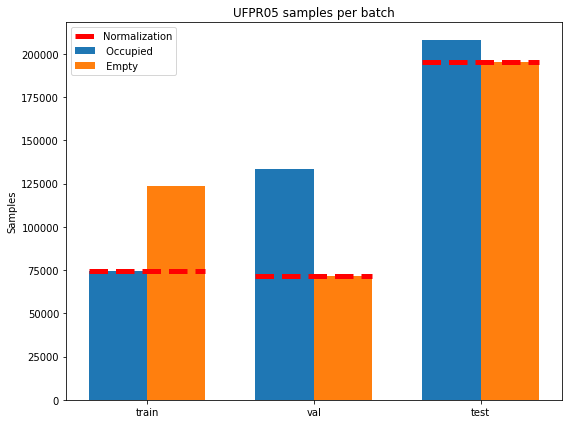

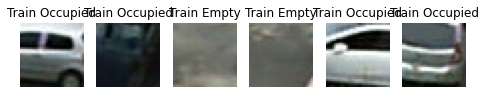

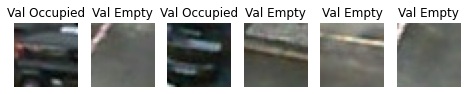

Epoch 1/20
4665/4665 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9392
Epoch 00001: val_loss improved from inf to 0.09956, saving model to UFPR05-Patches-32x32-with-aug/UFPR05-Patches-32x32-with-aug-checkpoint
4665/4665 [==============================] - 85s 18ms/step - loss: 0.1675 - accuracy: 0.9392 - val_loss: 0.0996 - val_accuracy: 0.9640
Epoch 2/20
4658/4665 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9729
Epoch 00002: val_loss improved from 0.09956 to 0.07994, saving model to UFPR05-Patches-32x32-with-aug/UFPR05-Patches-32x32-with-aug-checkpoint
4665/4665 [==============================] - 67s 14ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 0.0799 - val_accuracy: 0.9704
Epoch 3/20
4662/4665 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9807
Epoch 00003: val_loss improved from 0.07994 to 0.06917, saving model to UFPR05-Patches-32x32-with-aug/UFPR05-Patches-32x32-with-aug-checkpoint
4665/4665 [

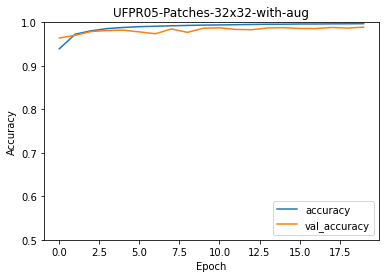

UFPR04-Poly-32x32-with-aug
Data Range:  ['2012-12-07' '2012-12-08' '2012-12-11' '2012-12-12' '2012-12-13'
 '2012-12-14' '2012-12-15' '2012-12-16' '2012-12-17' '2012-12-18'
 '2012-12-19' '2012-12-20' '2012-12-21' '2012-12-22' '2012-12-23'
 '2012-12-24' '2012-12-25' '2012-12-26' '2012-12-27' '2012-12-28'
 '2012-12-29' '2013-01-15' '2013-01-16' '2013-01-17' '2013-01-18'
 '2013-01-19' '2013-01-20' '2013-01-21' '2013-01-22' '2013-01-29']
Number of Normalized Samples to  train  :  17122
Number of Normalized Samples to  val  :  18946
Number of Normalized Samples to  test  :  36068


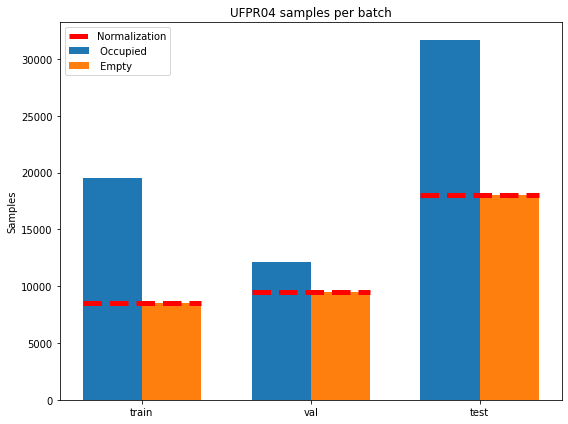

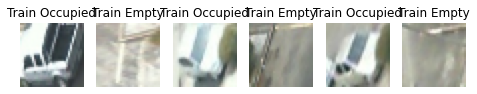

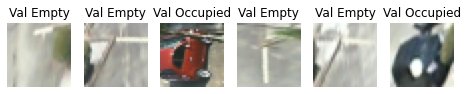

Epoch 1/20
536/536 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8557
Epoch 00001: val_loss improved from inf to 0.12543, saving model to UFPR04-Poly-32x32-with-aug/UFPR04-Poly-32x32-with-aug-checkpoint
536/536 [==============================] - 8s 14ms/step - loss: 0.3446 - accuracy: 0.8557 - val_loss: 0.1254 - val_accuracy: 0.9671
Epoch 2/20
533/536 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9880
Epoch 00002: val_loss improved from 0.12543 to 0.05029, saving model to UFPR04-Poly-32x32-with-aug/UFPR04-Poly-32x32-with-aug-checkpoint
536/536 [==============================] - 7s 14ms/step - loss: 0.0403 - accuracy: 0.9880 - val_loss: 0.0503 - val_accuracy: 0.9826
Epoch 3/20
533/536 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9916
Epoch 00003: val_loss did not improve from 0.05029
536/536 [==============================] - 7s 14ms/step - loss: 0.0288 - accuracy: 0.9915 - val_loss: 0.0770 - val_accuracy: 0.

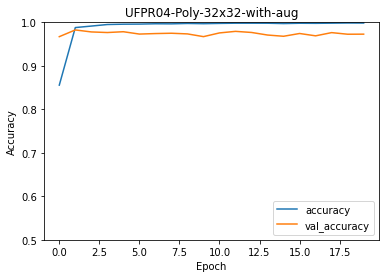

UFPR04-Bbox-32x32-with-aug
Data Range:  ['2012-12-07' '2012-12-08' '2012-12-11' '2012-12-12' '2012-12-13'
 '2012-12-14' '2012-12-15' '2012-12-16' '2012-12-17' '2012-12-18'
 '2012-12-19' '2012-12-20' '2012-12-21' '2012-12-22' '2012-12-23'
 '2012-12-24' '2012-12-25' '2012-12-26' '2012-12-27' '2012-12-28'
 '2012-12-29' '2013-01-15' '2013-01-16' '2013-01-17' '2013-01-18'
 '2013-01-19' '2013-01-20' '2013-01-21' '2013-01-22' '2013-01-29']
Number of Normalized Samples to  train  :  17122
Number of Normalized Samples to  val  :  18946
Number of Normalized Samples to  test  :  36068


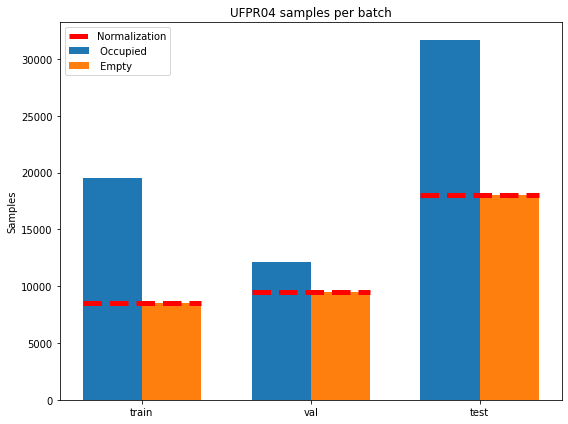

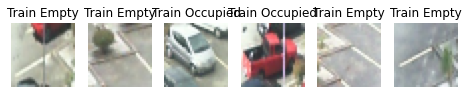

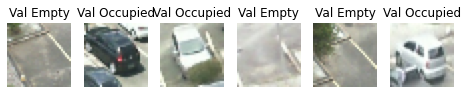

Epoch 1/20
523/536 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8889
Epoch 00001: val_loss improved from inf to 0.06525, saving model to UFPR04-Bbox-32x32-with-aug/UFPR04-Bbox-32x32-with-aug-checkpoint
536/536 [==============================] - 8s 14ms/step - loss: 0.3113 - accuracy: 0.8910 - val_loss: 0.0652 - val_accuracy: 0.9782
Epoch 2/20
533/536 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9866
Epoch 00002: val_loss did not improve from 0.06525
536/536 [==============================] - 8s 14ms/step - loss: 0.0437 - accuracy: 0.9867 - val_loss: 0.0736 - val_accuracy: 0.9764
Epoch 3/20
531/536 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9898
Epoch 00003: val_loss improved from 0.06525 to 0.06412, saving model to UFPR04-Bbox-32x32-with-aug/UFPR04-Bbox-32x32-with-aug-checkpoint
536/536 [==============================] - 8s 14ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.0641 - val_accuracy: 0.

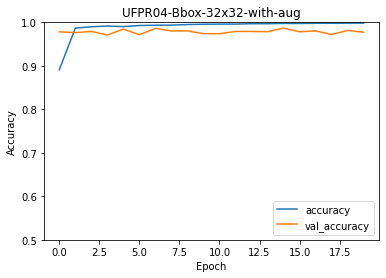

UFPR04-Centroid-32x32-with-aug
Data Range:  ['2012-12-07' '2012-12-08' '2012-12-11' '2012-12-12' '2012-12-13'
 '2012-12-14' '2012-12-15' '2012-12-16' '2012-12-17' '2012-12-18'
 '2012-12-19' '2012-12-20' '2012-12-21' '2012-12-22' '2012-12-23'
 '2012-12-24' '2012-12-25' '2012-12-26' '2012-12-27' '2012-12-28'
 '2012-12-29' '2013-01-15' '2013-01-16' '2013-01-17' '2013-01-18'
 '2013-01-19' '2013-01-20' '2013-01-21' '2013-01-22' '2013-01-29']
Number of Normalized Samples to  train  :  17122
Number of Normalized Samples to  val  :  18946
Number of Normalized Samples to  test  :  36068


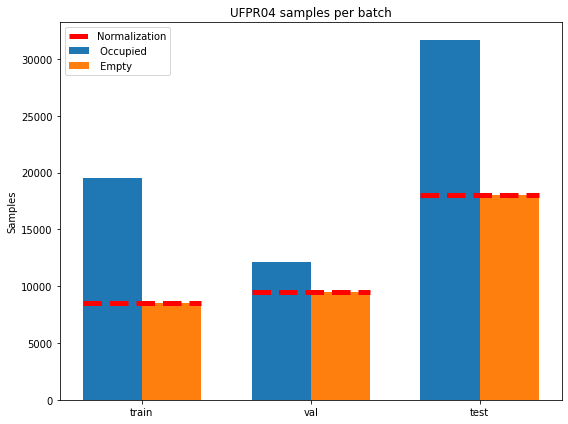

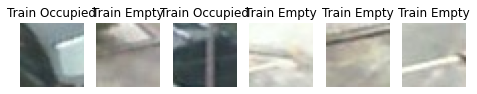

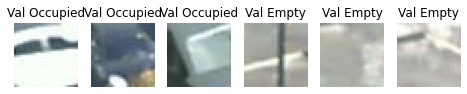

Epoch 1/20
532/536 [============================>.] - ETA: 0s - loss: 0.4345 - accuracy: 0.8496
Epoch 00001: val_loss improved from inf to 0.14246, saving model to UFPR04-Centroid-32x32-with-aug/UFPR04-Centroid-32x32-with-aug-checkpoint
536/536 [==============================] - 8s 14ms/step - loss: 0.4324 - accuracy: 0.8503 - val_loss: 0.1425 - val_accuracy: 0.9528
Epoch 2/20
529/536 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9781
Epoch 00002: val_loss did not improve from 0.14246
536/536 [==============================] - 8s 14ms/step - loss: 0.0664 - accuracy: 0.9776 - val_loss: 0.1817 - val_accuracy: 0.9539
Epoch 3/20
532/536 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9875
Epoch 00003: val_loss did not improve from 0.14246
536/536 [==============================] - 8s 14ms/step - loss: 0.0380 - accuracy: 0.9876 - val_loss: 0.1490 - val_accuracy: 0.9742
Epoch 4/20
533/536 [============================>.] - ETA: 0s - loss: 0.0

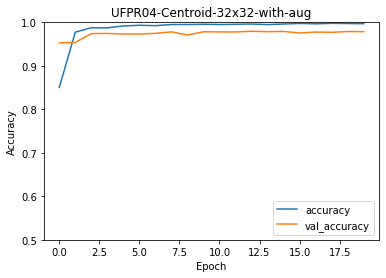

UFPR04-Patches-32x32-with-aug
Data Range:  ['2012-12-07' '2012-12-08' '2012-12-11' '2012-12-12' '2012-12-13'
 '2012-12-14' '2012-12-15' '2012-12-16' '2012-12-17' '2012-12-18'
 '2012-12-19' '2012-12-20' '2012-12-21' '2012-12-22' '2012-12-23'
 '2012-12-24' '2012-12-25' '2012-12-26' '2012-12-27' '2012-12-28'
 '2012-12-29' '2013-01-15' '2013-01-16' '2013-01-17' '2013-01-18'
 '2013-01-19' '2013-01-20' '2013-01-21' '2013-01-22' '2013-01-29']
Number of Normalized Samples to  train  :  85610
Number of Normalized Samples to  val  :  94730
Number of Normalized Samples to  test  :  180340


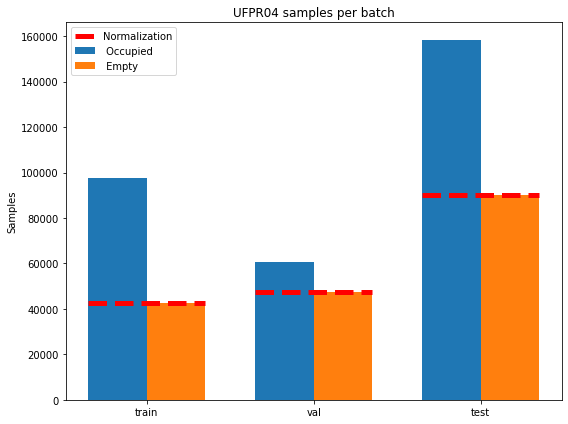

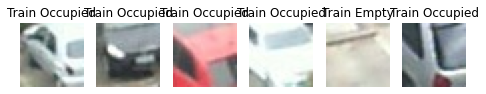

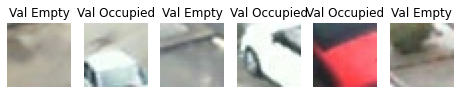

Epoch 1/20
2676/2676 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9209
Epoch 00001: val_loss improved from inf to 0.30919, saving model to UFPR04-Patches-32x32-with-aug/UFPR04-Patches-32x32-with-aug-checkpoint
2676/2676 [==============================] - 37s 14ms/step - loss: 0.1940 - accuracy: 0.9209 - val_loss: 0.3092 - val_accuracy: 0.9350
Epoch 2/20
2665/2676 [============================>.] - ETA: 0s - loss: 0.0653 - accuracy: 0.9792
Epoch 00002: val_loss improved from 0.30919 to 0.15379, saving model to UFPR04-Patches-32x32-with-aug/UFPR04-Patches-32x32-with-aug-checkpoint
2676/2676 [==============================] - 37s 14ms/step - loss: 0.0653 - accuracy: 0.9792 - val_loss: 0.1538 - val_accuracy: 0.9642
Epoch 3/20
2667/2676 [============================>.] - ETA: 0s - loss: 0.0566 - accuracy: 0.9826
Epoch 00003: val_loss improved from 0.15379 to 0.14510, saving model to UFPR04-Patches-32x32-with-aug/UFPR04-Patches-32x32-with-aug-checkpoint
2676/2676 [

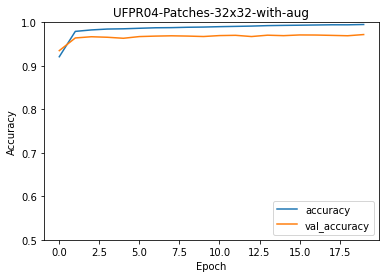

PUCPR-Poly-32x32-with-aug
Data Range:  ['2012-09-11' '2012-09-12' '2012-09-13' '2012-09-14' '2012-09-15'
 '2012-09-16' '2012-09-17' '2012-09-18' '2012-09-19' '2012-09-20'
 '2012-09-21' '2012-09-28' '2012-09-29' '2012-10-05' '2012-10-09'
 '2012-10-11' '2012-10-12' '2012-10-13' '2012-10-14' '2012-10-15'
 '2012-10-17' '2012-10-23' '2012-10-25' '2012-10-26' '2012-10-27'
 '2012-10-28' '2012-10-29' '2012-10-30' '2012-10-31' '2012-11-06'
 '2012-11-07' '2012-11-08' '2012-11-09' '2012-11-10' '2012-11-11'
 '2012-11-20']
Number of Normalized Samples to  train  :  128726
Number of Normalized Samples to  val  :  64560
Number of Normalized Samples to  test  :  221248


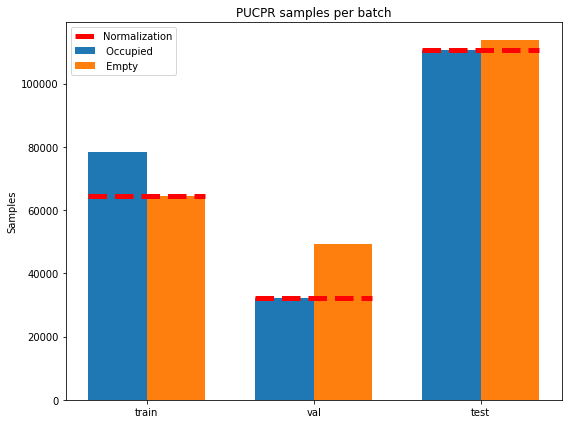

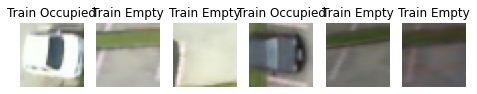

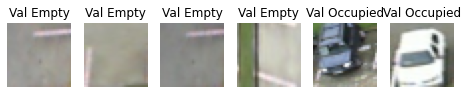

Epoch 1/20
4023/4023 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9885
Epoch 00001: val_loss improved from inf to 0.01466, saving model to PUCPR-Poly-32x32-with-aug/PUCPR-Poly-32x32-with-aug-checkpoint
4023/4023 [==============================] - 41s 10ms/step - loss: 0.0489 - accuracy: 0.9885 - val_loss: 0.0147 - val_accuracy: 0.9979
Epoch 2/20
4011/4023 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9965
Epoch 00002: val_loss improved from 0.01466 to 0.01339, saving model to PUCPR-Poly-32x32-with-aug/PUCPR-Poly-32x32-with-aug-checkpoint
4023/4023 [==============================] - 42s 10ms/step - loss: 0.0143 - accuracy: 0.9965 - val_loss: 0.0134 - val_accuracy: 0.9978
Epoch 3/20
4013/4023 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9975
Epoch 00003: val_loss improved from 0.01339 to 0.01233, saving model to PUCPR-Poly-32x32-with-aug/PUCPR-Poly-32x32-with-aug-checkpoint
4023/4023 [========================

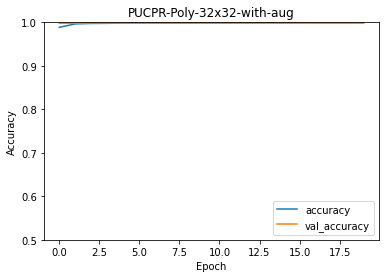

PUCPR-Bbox-32x32-with-aug
Data Range:  ['2012-09-11' '2012-09-12' '2012-09-13' '2012-09-14' '2012-09-15'
 '2012-09-16' '2012-09-17' '2012-09-18' '2012-09-19' '2012-09-20'
 '2012-09-21' '2012-09-28' '2012-09-29' '2012-10-05' '2012-10-09'
 '2012-10-11' '2012-10-12' '2012-10-13' '2012-10-14' '2012-10-15'
 '2012-10-17' '2012-10-23' '2012-10-25' '2012-10-26' '2012-10-27'
 '2012-10-28' '2012-10-29' '2012-10-30' '2012-10-31' '2012-11-06'
 '2012-11-07' '2012-11-08' '2012-11-09' '2012-11-10' '2012-11-11'
 '2012-11-20']
Number of Normalized Samples to  train  :  128726
Number of Normalized Samples to  val  :  64560
Number of Normalized Samples to  test  :  221248


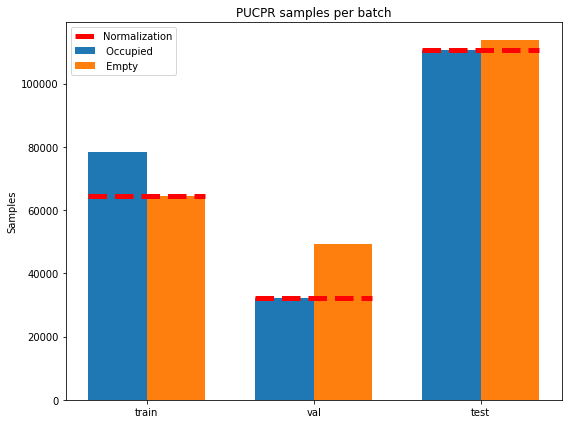

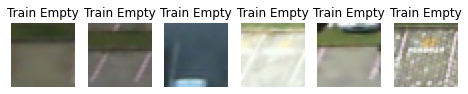

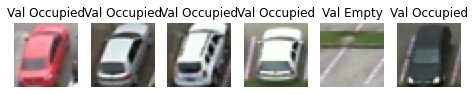

Epoch 1/20
4018/4023 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9859
Epoch 00001: val_loss improved from inf to 0.01722, saving model to PUCPR-Bbox-32x32-with-aug/PUCPR-Bbox-32x32-with-aug-checkpoint
4023/4023 [==============================] - 42s 10ms/step - loss: 0.0601 - accuracy: 0.9859 - val_loss: 0.0172 - val_accuracy: 0.9977
Epoch 2/20
4022/4023 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9968
Epoch 00002: val_loss improved from 0.01722 to 0.01562, saving model to PUCPR-Bbox-32x32-with-aug/PUCPR-Bbox-32x32-with-aug-checkpoint
4023/4023 [==============================] - 41s 10ms/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.0156 - val_accuracy: 0.9981
Epoch 3/20
4019/4023 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9978
Epoch 00003: val_loss improved from 0.01562 to 0.01504, saving model to PUCPR-Bbox-32x32-with-aug/PUCPR-Bbox-32x32-with-aug-checkpoint
4023/4023 [========================

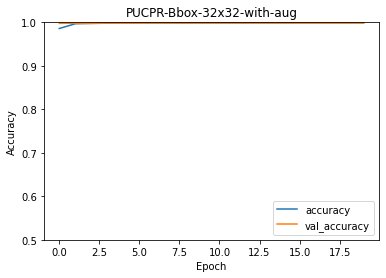

PUCPR-Centroid-32x32-with-aug
Data Range:  ['2012-09-11' '2012-09-12' '2012-09-13' '2012-09-14' '2012-09-15'
 '2012-09-16' '2012-09-17' '2012-09-18' '2012-09-19' '2012-09-20'
 '2012-09-21' '2012-09-28' '2012-09-29' '2012-10-05' '2012-10-09'
 '2012-10-11' '2012-10-12' '2012-10-13' '2012-10-14' '2012-10-15'
 '2012-10-17' '2012-10-23' '2012-10-25' '2012-10-26' '2012-10-27'
 '2012-10-28' '2012-10-29' '2012-10-30' '2012-10-31' '2012-11-06'
 '2012-11-07' '2012-11-08' '2012-11-09' '2012-11-10' '2012-11-11'
 '2012-11-20']
Number of Normalized Samples to  train  :  128726
Number of Normalized Samples to  val  :  64560
Number of Normalized Samples to  test  :  221248


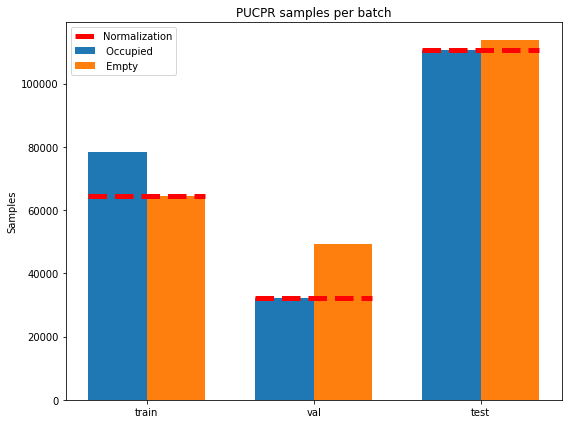

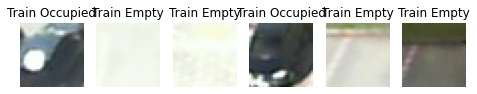

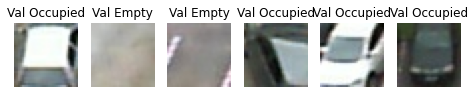

Epoch 1/20
4019/4023 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9772
Epoch 00001: val_loss improved from inf to 0.03613, saving model to PUCPR-Centroid-32x32-with-aug/PUCPR-Centroid-32x32-with-aug-checkpoint
4023/4023 [==============================] - 42s 10ms/step - loss: 0.0742 - accuracy: 0.9772 - val_loss: 0.0361 - val_accuracy: 0.9890
Epoch 2/20
4020/4023 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.9947
Epoch 00002: val_loss improved from 0.03613 to 0.02285, saving model to PUCPR-Centroid-32x32-with-aug/PUCPR-Centroid-32x32-with-aug-checkpoint
4023/4023 [==============================] - 42s 10ms/step - loss: 0.0218 - accuracy: 0.9947 - val_loss: 0.0229 - val_accuracy: 0.9971
Epoch 3/20
4016/4023 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9962
Epoch 00003: val_loss improved from 0.02285 to 0.01998, saving model to PUCPR-Centroid-32x32-with-aug/PUCPR-Centroid-32x32-with-aug-checkpoint
4023/4023 [

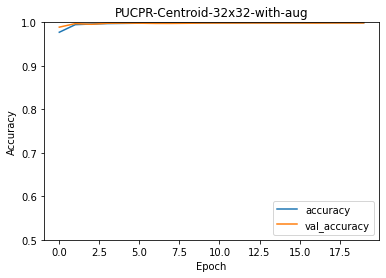

PUCPR-Patches-32x32-with-aug
Data Range:  ['2012-09-11' '2012-09-12' '2012-09-13' '2012-09-14' '2012-09-15'
 '2012-09-16' '2012-09-17' '2012-09-18' '2012-09-19' '2012-09-20'
 '2012-09-21' '2012-09-28' '2012-09-29' '2012-10-05' '2012-10-09'
 '2012-10-11' '2012-10-12' '2012-10-13' '2012-10-14' '2012-10-15'
 '2012-10-17' '2012-10-23' '2012-10-25' '2012-10-26' '2012-10-27'
 '2012-10-28' '2012-10-29' '2012-10-30' '2012-10-31' '2012-11-06'
 '2012-11-07' '2012-11-08' '2012-11-09' '2012-11-10' '2012-11-11'
 '2012-11-20']
Number of Normalized Samples to  train  :  643630
Number of Normalized Samples to  val  :  322800
Number of Normalized Samples to  test  :  1106240


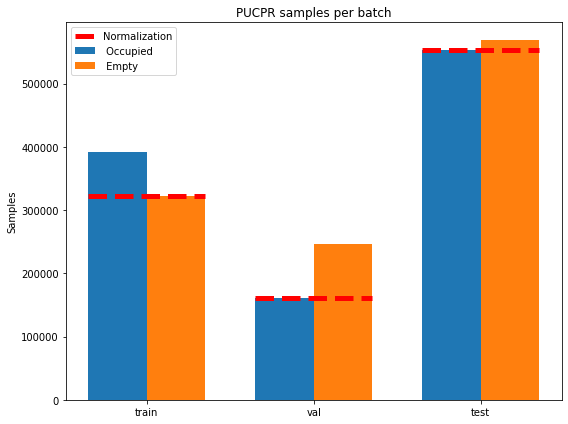

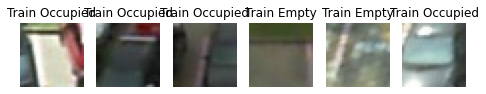

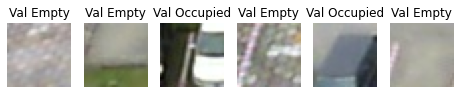

Epoch 1/20
20114/20114 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9631
Epoch 00001: val_loss improved from inf to 0.06293, saving model to PUCPR-Patches-32x32-with-aug/PUCPR-Patches-32x32-with-aug-checkpoint
20114/20114 [==============================] - 231s 11ms/step - loss: 0.0988 - accuracy: 0.9631 - val_loss: 0.0629 - val_accuracy: 0.9781
Epoch 2/20
20110/20114 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9819
Epoch 00002: val_loss improved from 0.06293 to 0.04066, saving model to PUCPR-Patches-32x32-with-aug/PUCPR-Patches-32x32-with-aug-checkpoint
20114/20114 [==============================] - 212s 11ms/step - loss: 0.0487 - accuracy: 0.9819 - val_loss: 0.0407 - val_accuracy: 0.9870
Epoch 3/20
20108/20114 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9870
Epoch 00003: val_loss improved from 0.04066 to 0.03968, saving model to PUCPR-Patches-32x32-with-aug/PUCPR-Patches-32x32-with-aug-checkpoint
20114

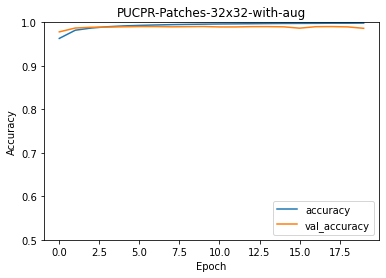

In [ ]:
for augment in [True]:
  for PKLOT_NAME in TRAIN_PKLOTS:
    for ANN_TYPE in ANN_TYPES:

      if augment:
        compl = '-with-aug'
      else:
        compl = '-without-aug'

      workingdir = PKLOT_NAME + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + compl
      print(workingdir)    
      pathlib.Path(workingdir).mkdir(parents=True, exist_ok=True)

      list_of_files = 'PKLot/list-' + PKLOT_NAME + '-' + ANN_TYPE + '.txt'
      
      #Eliminates noise files
      #!sed -i '/txt/d'  $list_of_files 
      #!sed -i '/list/d'  $list_of_files 
      #!sed -i '$ d' $list_of_files
      
      #Convert path to colab
      #!sed -i 's/\/home\/aghochuli\/Datasets\/PKLot\///g' $list_of_files

      with open(list_of_files,'r') as myfile:
              files = myfile.read().splitlines()

      data = []
      
      for fname in files:       

          date = re.findall('\d\d\d\d-\d\d-\d\d',fname)
          
          if fname.find('Empty') > 0:
              cls = 0                 
          else:
              cls = 1        
              

          data.append([date[0],cls,fname])     
      
      df = pd.DataFrame(data, columns = ['DATE', 'CLASS', 'PATH'])
      df = df.sample(frac=1).reset_index(drop=True)

      pklot = df
      dates = pd.unique(pklot['DATE'])
      dates = np.sort(dates)
      stats = []
      print('Data Range: ', dates)
      split = int(dates.shape[0]*.5)
      train = dates[split:]
      test = dates[:split]

      split = int(train.shape[0]*.6)
      val = train[split:]
      train = train[:split]

      batches = []
      for dates,batch_name in zip([train,val,test],['train','val','test']):

          date_df = pklot.loc[pklot['DATE'].between(dates[0],dates[-1])]    
          date_df = date_df.sample(frac=1).reset_index(drop=True)
          n_occupied = date_df.loc[date_df['CLASS'] == 1]    
          n_empty = date_df.loc[date_df['CLASS'] == 0]
        
          diff = n_empty.shape[0] - n_occupied.shape[0] 

          if(diff > 0):
            drop_indices = np.random.choice(n_empty.index, diff, replace=False)
          else: #Occupied  
            diff *= -1
            drop_indices = np.random.choice(n_occupied.index, diff, replace=False)

          
          df_subset = date_df.drop(drop_indices)       
          
          batches.append(df_subset['PATH'].to_list())  
          
          occupied = date_df['CLASS'] == 1    
          n_empty,n_occupied = np.unique(occupied,return_counts=True)[1]
          stats.append([batch_name,n_empty,n_occupied])  
          print('Number of Normalized Samples to ', batch_name,' : ', len(batches[-1]))

      
      title = PKLOT_NAME + ' samples per batch'

      fig_path = workingdir + '/' + workingdir + '-protocol.jpg'
      plot_stats(stats,title,figsize=(8,6),save_path = fig_path)


      #input_dataset = tf.data.TextLineDataset(batches[0])
      train_dataset = tf.data.Dataset.from_tensor_slices(batches[0])

      train_dataset = train_dataset.map(lambda x: load_image(x,augment),
                                        num_parallel_calls=tf.data.AUTOTUNE)
      train_dataset = train_dataset.shuffle(BUFFER_SIZE)
      train_dataset = train_dataset.batch(BATCH_SIZE)

      val_dataset = tf.data.Dataset.from_tensor_slices(batches[1])

      val_dataset = val_dataset.map(lambda x: load_image(x,augment),
                                        num_parallel_calls=tf.data.AUTOTUNE)
      val_dataset = val_dataset.shuffle(BUFFER_SIZE)
      val_dataset = val_dataset.batch(BATCH_SIZE)

      plt.figure(figsize=(8, 6))  
      class_names = ['Empty','Occupied']
      images,labels = next(iter(train_dataset.take(1)))    
      for i in range(6):
        ax = plt.subplot(1, 6, i + 1)    
        im = tf.keras.utils.img_to_array(images[i])
        plt.imshow(im)  
        lbl = class_names[int(labels[i])]
        
        plt.title('Train ' + lbl)
        plt.axis("off")

      fig_path = workingdir + '/' + workingdir + '-train_samples.jpg'
      plt.savefig(fig_path)
      plt.show()

      plt.figure(figsize=(8, 6))  
      class_names = ['Empty','Occupied']
      images,labels = next(iter(val_dataset.take(1)))
      for i in range(6):
        ax = plt.subplot(1, 6, i + 1)    
        im = tf.keras.utils.img_to_array(images[i])
        plt.imshow(im)  
        lbl = class_names[int(labels[i])]
        plt.title('Val ' + lbl)
        plt.axis("off")

      fig_path = workingdir + '/' + workingdir + '-val_samples.jpg'
      plt.savefig(fig_path)
      plt.show()

      checkpoint_filepath = workingdir + '/' + workingdir + '-checkpoint'

      #Monitorar o val loss para salvar os pesos
      model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)
      
      input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)

      try:
          del model
      except NameError:
          model = None

      #define and compile model
      model = PKLOT_NET(input_shape, 2)
      
      model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      #model.summary()
          

      history = model.fit(train_dataset, epochs=EPOCHS, shuffle=True,  
                batch_size=BATCH_SIZE, validation_data=val_dataset, callbacks=[model_checkpoint])

      history = json.dump(history.history, open(workingdir + '/' + workingdir + '-history.json', 'w'))

      history_dict = json.load(open(workingdir + '/' + workingdir + '-history.json'))
      plt.plot(history_dict['accuracy'], label='accuracy')
      plt.plot(history_dict['val_accuracy'], label = 'val_accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.ylim([0.5, 1])
      plt.title(workingdir)
      plt.legend(loc='lower right')
          
      fig_path = workingdir + '/' + workingdir + '-training_history.jpg'
      plt.savefig(fig_path)
      plt.show()

      !cp -r $workingdir '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/'

#Experiments

## Cross-Domain

In [ ]:
import pickle

acc_dict = {} 

#Test with ou without transfer-learning (tl)

#for TF in [True,False]:
for TF in [False]:
  #Test with ou without AUGMENTATION 
  for augment in [True]:
    if augment:
        compl = '-with-aug'
    else:
        compl = '-without-aug'

    if augment == False:        
        save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_without-tl' + compl + '.dict'
    elif augment == True:        
        save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_with-tl' + compl + '.dict'
        
    if os.path.exists(save_path):        
        dict_file = open(save_path,'rb')
        acc_dict = pickle.load(dict_file)
        dict_file.close()  

    for PKLOT_TRAIN in TRAIN_PKLOTS:  
      acc_dict[PKLOT_TRAIN] = {} 

      for PKLOT_TARGET in TARGET_PKLOTS:
        acc_dict[PKLOT_TRAIN][PKLOT_TARGET] = {}
        for ANN_TYPE in ['Poly','Bbox','Centroid']:

          list_of_files = 'PKLot/list-' + PKLOT_TARGET + '-' + ANN_TYPE + '.txt'
          
          #Eliminates noise files
          !sed -i '/txt/d'  $list_of_files 
          !sed -i '/list/d'  $list_of_files 
          !sed -i '$ d' $list_of_files
          
          with open(list_of_files,'r') as myfile:
                  files = myfile.read().splitlines()

          data = []

          for fname in files:        
              date = re.findall('\d\d\d\d-\d\d-\d\d',fname)
              if fname.find('Empty') > 0:
                  cls = 0
              else:
                  cls = 1        

              data.append([date[0],cls,fname])     

          df = pd.DataFrame(data, columns = ['DATE', 'CLASS', 'PATH'])
          df = df.sample(frac=1).reset_index(drop=True)

          pklot = df
          dates = pd.unique(pklot['DATE'])
          dates = np.sort(dates)
          stats = []      
          split = int(dates.shape[0]*.5)
          train = dates[split:]
          test = dates[:split]

          split = int(train.shape[0]*.6)
          val = train[split:]
          train = train[:split]

          batches = []
          for dates,batch_name in zip([train,val,test],['train','val','test']):

              date_df = pklot.loc[pklot['DATE'].between(dates[0],dates[-1])]    
              date_df = date_df.sample(frac=1).reset_index(drop=True)
              n_occupied = date_df.loc[date_df['CLASS'] == 1]    
              n_empty = date_df.loc[date_df['CLASS'] == 0]
            
              diff = n_empty.shape[0] - n_occupied.shape[0] 

              if(diff > 0):
                drop_indices = np.random.choice(n_empty.index, diff, replace=False)
              else: #Occupied  
                diff *= -1
                drop_indices = np.random.choice(n_occupied.index, diff, replace=False)

              
              df_subset = date_df.drop(drop_indices)       
              
              batches.append(df_subset['PATH'].to_list())  
              
              occupied = date_df['CLASS'] == 1    
              n_empty,n_occupied = np.unique(occupied,return_counts=True)[1]
              stats.append([batch_name,n_empty,n_occupied])  
          
          
          test_dataset = tf.data.Dataset.from_tensor_slices(batches[2])
          test_dataset = test_dataset.map(load_image,
                                            num_parallel_calls=tf.data.AUTOTUNE)
          test_dataset = test_dataset.shuffle(BUFFER_SIZE)
          test_dataset = test_dataset.batch(BATCH_SIZE)

          input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)

          try:
              del model
          except NameError:
              model = None


          
          model = PKLOT_NET(input_shape, 2)
          model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
          
          

          if TF == False:
            weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + compl + '/'
            save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_without-tl' + compl + '.dict'
          elif TF == True:
            weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + 'x' + PKLOT_TARGET + '-' + ANN_TYPE + '-' +  IMG_SIZE[0] + 'x' + IMG_SIZE[1] + compl + '/'
            save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_with-tl' + compl + '.dict'
          
            



          print(weights_path)

          latest = tf.train.latest_checkpoint(weights_path)
          model.load_weights(latest).expect_partial()
          if TF:
            print('Evaluating ', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE: ', ANN_TYPE, "With TF-",compl)
          else: 
            print('Evaluating ', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE: ', ANN_TYPE, "Without TF-",compl)

          test_loss, test_acc = model.evaluate(test_dataset,batch_size=BATCH_SIZE)
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE] = {} 
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['loss'] = test_loss
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['acc'] = test_acc
        
    a_file = open(save_path, "wb")
    pickle.dump(acc_dict, a_file)
    a_file.close()

/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Poly-32x32-with-aug/
Evaluating  UFPR05 -> UFPR05  ANN_TYPE:  Poly Without TF- -with-aug
2442/2442 [==============================] - 17s 7ms/step - loss: 0.0137 - accuracy: 0.9956
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Bbox-32x32-with-aug/
Evaluating  UFPR05 -> UFPR05  ANN_TYPE:  Bbox Without TF- -with-aug
2442/2442 [==============================] - 17s 7ms/step - loss: 0.0111 - accuracy: 0.9965
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Centroid-32x32-with-aug/
Evaluating  UFPR05 -> UFPR05  ANN_TYPE:  Centroid Without TF- -with-aug
2442/2442 [==============================] - 15s 6ms/step - loss: 0.0294 - accuracy: 0.9892
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Poly-32x32-with-aug/
Evaluating  UFPR05 -> UFPR04  ANN_TYPE:  Poly Without TF- -with-aug
1128/1128 [==============================] - 7s 6ms/step - loss: 0.2420 - accuracy: 0.8949
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Bbox-32x32-with-aug/
Evaluating  UFPR05

## Cross-Domain Patch-Based (Majority Vote)

In [ ]:
import pickle

#Test with ou without transfer-learning (tf)
#for TF in [True,False]:
for TF in [False]:
  for augment in [True,False]:
    if augment:
        compl = '-with-aug'
    else:
        compl = '-without-aug'
    
    if TF == False:
      weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + compl + '/'
      save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_without-tl' + compl + '.dict'
    elif TF == True:
      weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + 'x' + PKLOT_TARGET + '-' + ANN_TYPE + '-' +  IMG_SIZE[0] + 'x' + IMG_SIZE[1] + compl + '/'
      save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_with-tl' + compl + '.dict'
    
    dict_file = open(save_path,'rb')
    acc_dict = pickle.load(dict_file)
    dict_file.close()
          
    for PKLOT_TRAIN in TRAIN_PKLOTS:      
      for PKLOT_TARGET in TARGET_PKLOTS:           
        for ANN_TYPE in ['Patches']:
          #workingdir = 'TEST-' PKLOT_TRAIN + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1])

          #pathlib.Path(workingdir).mkdir(parents=True, exist_ok=True)

          list_of_files = 'PKLot/list-' + PKLOT_TARGET + '-' + ANN_TYPE + '.txt'
          
          with open(list_of_files,'r') as myfile:
                  files = myfile.read().splitlines()

          data = []

          for fname in files:        
              date = re.findall('\d\d\d\d-\d\d-\d\d',fname)
              if fname.find('Empty') > 0:
                  cls = 0
              else:
                  cls = 1        

              data.append([date[0],cls,fname])     

          df = pd.DataFrame(data, columns = ['DATE', 'CLASS', 'PATH'])
          df = df.sample(frac=1).reset_index(drop=True)

          pklot = df
          dates = pd.unique(pklot['DATE'])
          dates = np.sort(dates)
          stats = []      
          split = int(dates.shape[0]*.5)
          train = dates[:split]
          test = dates[:split]

          split = int(train.shape[0]*.6)
          val = train[split:]
          train = train[:split]

          batches = []
          for dates,batch_name in zip([train,val,test],['train','val','test']):

              date_df = pklot.loc[pklot['DATE'].between(dates[0],dates[-1])]    
              date_df = date_df.sample(frac=1).reset_index(drop=True)
              n_occupied = date_df.loc[date_df['CLASS'] == 1]    
              n_empty = date_df.loc[date_df['CLASS'] == 0]
            
              diff = n_empty.shape[0] - n_occupied.shape[0] 

              if(diff > 0):
                drop_indices = np.random.choice(n_empty.index, diff, replace=False)
              else: #Occupied  
                diff *= -1
                drop_indices = np.random.choice(n_occupied.index, diff, replace=False)

              
              df_subset = date_df.drop(drop_indices)       
              
              batches.append(df_subset['PATH'].to_list())  
              
              occupied = date_df['CLASS'] == 1    
              n_empty,n_occupied = np.unique(occupied,return_counts=True)[1]
              stats.append([batch_name,n_empty,n_occupied])  
          
          

          test_dataset = tf.data.Dataset.from_tensor_slices(batches[2])
          test_dataset = test_dataset.map(load_image,
                                            num_parallel_calls=tf.data.AUTOTUNE)
          test_dataset = test_dataset.shuffle(BUFFER_SIZE)
          test_dataset = test_dataset.batch(BATCH_SIZE)

          input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)

          try:
              del model
          except NameError:
              model = None


          #model = VGG4PKLOT(input_shape, 2) 
          model = PKLOT_NET(input_shape, 2)
          model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
          
          

          if TF == False:
            weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + compl + '/'
            save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_patches_dict_without-tl' + compl + '.dict'
          elif TF == True:
            weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + 'x' + PKLOT_TARGET + '-' + ANN_TYPE + '-' +  IMG_SIZE[0] + 'x' + IMG_SIZE[1] + compl + '/'
            save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_patches_dict_with-tl' + compl + '.dict'
          
          print(weights_path)

          latest = tf.train.latest_checkpoint(weights_path)
          model.load_weights(latest).expect_partial()
          if TF:
            print('Evaluating ', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE : ', ANN_TYPE, 'With TL: ')
          else: 
            print('Evaluating ', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE: ', ANN_TYPE, 'Without TL: ')
          
          count = 0
          ok = 0
          error = 0
          size = int(len(batches[2])/5)
          print("Total Iters:", size)
          print('\rThinking: 0',end='')
          BUFFER_PATCHES = 0
          data = np.array([])
          labels = np.array([])

          BUFFER_IMGS = 5*10
          for path in batches[2]:
            if path.find('Patch0.jpg') == -1:
              continue
            
            count += 1
            if(count % 50 == 0):
              print('\r Iter: ',count, 'Result = ', float(ok) / float(count), end=' ')  

            for i in range(5):
              path = path[:-5] + str(i) + '.jpg'
              inf = load_image(path,augment)
              data= np.append(data,inf[0])
              labels = np.append(labels,inf[1])

            BUFFER_PATCHES += 5            
            if BUFFER_PATCHES < BUFFER_IMGS:
              continue
            

            
            data = np.reshape(data,(BUFFER_PATCHES,input_shape[0],input_shape[1],input_shape[2]))
            

            
            res = model.predict(data,batch_size=32)
            #res = model(data,training='False')
            
            
            n_preds = int(BUFFER_PATCHES/5)            
            res = np.reshape(res, (n_preds,5,2))
            labels = np.reshape(labels, (n_preds,5))
            
            for slot,label in zip(res,labels):              
              for s,lbl in zip(slot,label):          
                if np.argmax(s) == lbl:
                  votes.append(1)
                else:
                  votes.append(0)
              
              if np.sum(votes) > 2:
                ok += 1
              else:
                error += 1
          
            
              BUFFER_PATCHES = 0
              data = np.array([])
              labels = np.array([])
              votes = []

          print('\nResult: ', float(ok) / float(count))
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE] = {} 
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['loss'] = float(error) / float(count)
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['acc'] = float(ok) / float(count)      

          
          a_file = open(save_path, "wb")
          pickle.dump(acc_dict, a_file)
          a_file.close()

/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Patches-32x32-with-aug/
Evaluating  UFPR05 -> UFPR05  ANN_TYPE:  Patches Without TL: 
Total Iters: 78122
 Iter:  78050 Result =  0.9392312620115311 
Result:  0.9392918880850246
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Patches-32x32-with-aug/
Evaluating  UFPR05 -> UFPR04  ANN_TYPE:  Patches Without TL: 
Total Iters: 36068
 Iter:  36250 Result =  0.566151724137931 
Result:  0.5662547580956584
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR05-Patches-32x32-with-aug/
Evaluating  UFPR05 -> PUCPR  ANN_TYPE:  Patches Without TL: 
Total Iters: 221248
 Iter:  221250 Result =  0.7289491525423729 
Result:  0.7289629241309495
/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/UFPR04-Patches-32x32-with-aug/
Evaluating  UFPR04 -> UFPR05  ANN_TYPE:  Patches Without TL: 
Total Iters: 78122
 Iter:  24350 Result =  0.6452977412731006 

KeyboardInterrupt: ignored

## Plot Rates

In [ ]:
fontsize = 9
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': fontsize,
        }

def autolabel(rects, ax, txt_label):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
    # print(dir(rect))

      height = 0
      if rect.get_y() < 0:
          height = rect.get_y()
      else:
          height = rect.get_height()

      # Fraction of axis height taken up by this rectangle
      p_height = (height / y_height)
      # If we can fit the label above the column, do that;
      # otherwise, put it inside the column.
      if p_height > 1.00:  # arbitrary; 95% looked good to me.
          label_position = height - (y_height * 0.05)
      else:
          label_position = height + (y_height * 0.01)

      ax.text(rect.get_x() + rect.get_width() / 2., label_position,
              '%s' % txt_label,
              ha='center', va='bottom',fontsize=fontsize)

##Generate

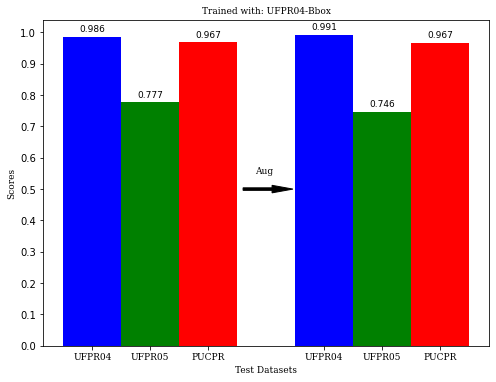

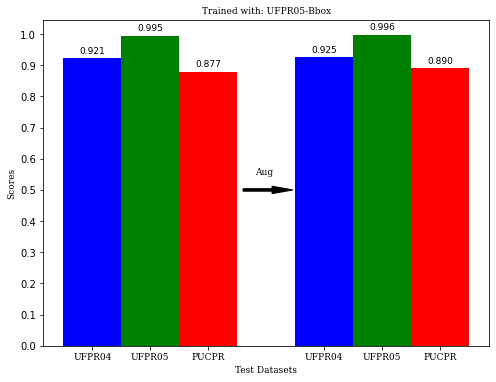

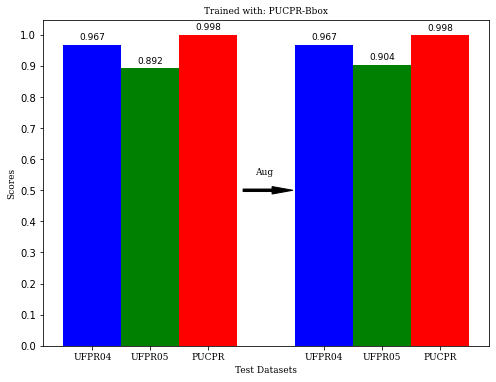

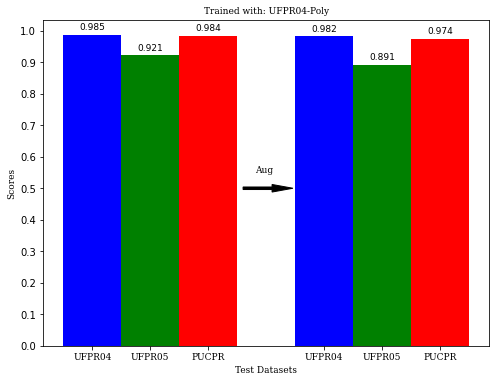

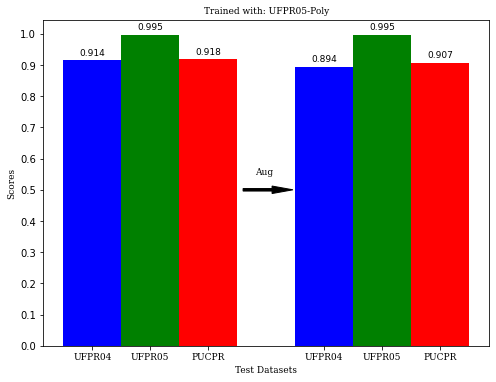

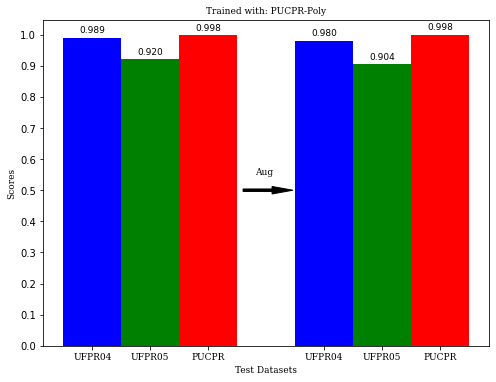

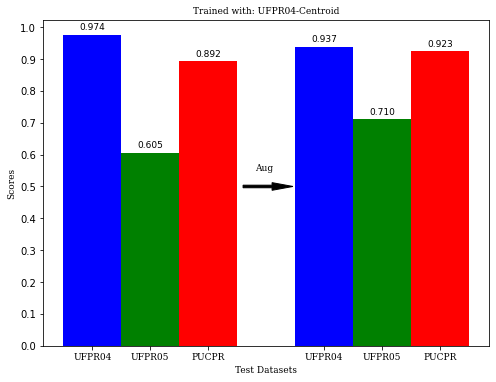

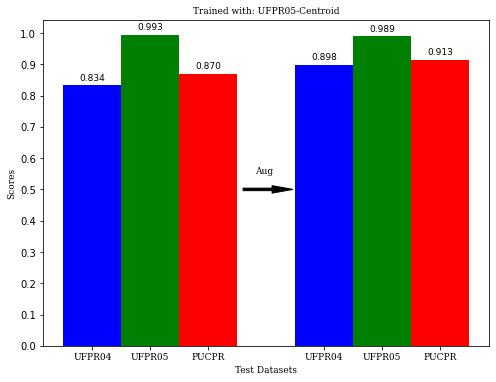

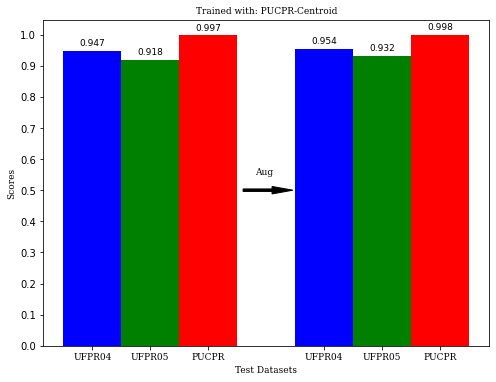

In [ ]:
results = {}
for augment in [False,True]:
    if augment:
        aug_text = 'with-aug'        
    else:
        aug_text = 'without-aug'
        
    dict_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_without-tl-' + aug_text + '.dict'
    dict_file = open(dict_path,'rb')
    results[aug_text] = pickle.load(dict_file)
    dict_file.close()

for ann in ['Bbox','Poly','Centroid']:
  for source in ['UFPR04','UFPR05','PUCPR']:
    offset = 0
    labels = []
    xticks = []
    width = 0.1  # the width of the bars
    fig, ax = plt.subplots(figsize=(8, 6))

    for dt_type in ['without-aug','with-aug']:
      
      offset += 1 
      
      res_dict = results[dt_type][source]
      lenght = len(results[dt_type][source])
      
      for target, color in zip(['UFPR04','UFPR05','PUCPR'],['blue','green','red']):
        labels.append(target)
        acc = res_dict[target][ann]['acc']
        #print(dt_type,ann,source,target,acc)
        rect = ax.bar(width + (offset*width), acc , width, label=target, color=color,)
        offset += 1
        autolabel(rect,ax,str(acc)[:5])
        xticks.append((offset)*width)   

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores',fontdict=font)
    ax.set_xlabel('Test Datasets',fontdict=font)
    ax.set_title('Trained with: ' + source + '-' + ann,fontdict=font)
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(0.0,1.01,0.10))
    ax.set_xticklabels(labels,fontdict=font)
    
    ax.text(0.48, 0.55, 'Aug',fontdict=font)
    ax.arrow(0.46,0.5,0.05,0.0,width=0.008,color='black')
    save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + source + '-' + ann + '.jpg'
    plt.savefig(save_path)
  
    plt.show()
    
        

In [ ]:
!rm -rf FINETUNNED*

#FineTunning of classification layer (5 epoch)


In [ ]:
def create_dataset(list_of_files):
  with open(list_of_files,'r') as myfile:
                  files = myfile.read().splitlines()

  data = []

  for fname in files:        
      date = re.findall('\d\d\d\d-\d\d-\d\d',fname)
      if fname.find('Empty') > 0:
          cls = 0
      else:
          cls = 1        

      data.append([date[0],cls,fname])     

  df = pd.DataFrame(data, columns = ['DATE', 'CLASS', 'PATH'])
  df = df.sample(frac=1).reset_index(drop=True)

  pklot = df
  dates = pd.unique(pklot['DATE'])
  dates = np.sort(dates)  
  
  split = int(dates.shape[0]*.5)
  train = dates[split:]          

  split = int(train.shape[0]*.6)
  val = train[split:]
  train = train[:split]

  batches = []
  for dates,batch_name in zip([train,val],['train','val']):

      if batch_name == 'train':
        select_n_imgs = int(n_imgs/2)
      else:
        select_n_imgs = int((n_imgs/2)*0.3)

      date_df = pklot.loc[pklot['DATE'].between(dates[0],dates[-1])]    
      date_df = date_df.sample(frac=1).reset_index(drop=True)

      n_occupied = date_df.loc[date_df['CLASS'] == 1][:select_n_imgs]    
      n_empty = date_df.loc[date_df['CLASS'] == 0][:select_n_imgs]

      
      batches.append(n_occupied['PATH'].to_list() + n_empty['PATH'].to_list())  
      
      
      print('Number of Normalized Samples to ', batch_name,' : ', len(batches[-1]))
      random.shuffle(batches[-1])

  #input_dataset = tf.data.TextLineDataset(batches[0])
  
  train_dataset = tf.data.Dataset.from_tensor_slices(batches[0])

  train_dataset = train_dataset.map(lambda x: load_image(x,augment),
                                    num_parallel_calls=tf.data.AUTOTUNE)
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.batch(BATCH_SIZE)

  val_dataset = tf.data.Dataset.from_tensor_slices(batches[1])

  val_dataset = val_dataset.map(lambda x: load_image(x,augment),
                                    num_parallel_calls=tf.data.AUTOTUNE)
  val_dataset = val_dataset.shuffle(BUFFER_SIZE)
  val_dataset = val_dataset.batch(BATCH_SIZE)

  return train_dataset, val_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random


for PKLOT_TRAIN in TRAIN_PKLOTS:
  for PKLOT_TARGET in TARGET_PKLOTS:
    if PKLOT_TRAIN == PKLOT_TARGET:
      continue;

    for ANN_TYPE in ['Poly','Bbox','Centroid']:
      for augment in [False,True]:        
        for n_imgs in [50,100,200,500,1000,2000,5000,10000]:
          if augment:
            compl = '-with-aug'
          else:
            compl = '-without-aug'
          
          list_of_files = 'PKLot/list-' + PKLOT_TARGET + '-' + ANN_TYPE + '.txt'      
          
          train_dataset, val_dataset = create_dataset(list_of_files)

          for n_round in range(1,11):
            workingdir = 'FINETUNNED-' + str(n_imgs) + compl + '-' + PKLOT_TRAIN + 'x' + PKLOT_TARGET + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + '-ROUND-' + str(n_round)
            print(workingdir)
            pathlib.Path(workingdir).mkdir(parents=True, exist_ok=True)

            checkpoint_filepath = workingdir + '/' + workingdir + '-checkpoint'

            #Monitorar o val loss para salvar os pesos
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
              filepath=checkpoint_filepath,
              save_weights_only=True,
              monitor='val_loss',
              mode='min',
              save_best_only=True,
              verbose=0)
            
            input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)

            try:
                del model
            except NameError:
                model = None


            #define and compile model
            model = PKLOT_NET(input_shape, 2)
            
            for i in range(0,5):    
              model.layers[i].trainable = False

            model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            #model.summary()
            
            weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/' + PKLOT_TRAIN + '-' + ANN_TYPE + '-' + str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1]) + compl + '/'        
            

            latest = tf.train.latest_checkpoint(weights_path)
            model.load_weights(latest)
            #model.summary()

            history = model.fit(train_dataset, epochs=EPOCHS_FT, shuffle=True,  verbose=0,
                      batch_size=BATCH_SIZE, validation_data=val_dataset, callbacks=[model_checkpoint], )

            
            history = json.dump(history.history, open(workingdir + '/' + workingdir + '-history.json', 'w'))
            
            history_dict = json.load(open(workingdir + '/' + workingdir + '-history.json'))
            plt.plot(history_dict['accuracy'], label='accuracy')
            plt.plot(history_dict['val_accuracy'], label = 'val_accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.ylim([0.5, 1])
            plt.title(workingdir)
            plt.legend(loc='lower right')
                
            fig_path = workingdir + '/' + workingdir + '-training_history.jpg'
            plt.savefig(fig_path)
            #plt.show()
            plt. clf()
            #output.clear()
            dir_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/' + str(n_imgs) + '/'
            !mkdir $dir_path
            !cp -r $workingdir $dir_path
    

Number of Normalized Samples to  train  :  18561
Number of Normalized Samples to  val  :  6000
FINETUNNED-20000-without-aug-UFPR05xUFPR04-Poly-32x32-ROUND-1
mkdir: cannot create directory ‘/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/20000/’: File exists
Number of Normalized Samples to  train  :  28043
Number of Normalized Samples to  val  :  15000
FINETUNNED-50000-without-aug-UFPR05xUFPR04-Poly-32x32-ROUND-1
Number of Normalized Samples to  train  :  18561
Number of Normalized Samples to  val  :  6000
FINETUNNED-20000-with-aug-UFPR05xUFPR04-Poly-32x32-ROUND-1
mkdir: cannot create directory ‘/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/20000/’: File exists
Number of Normalized Samples to  train  :  28043
Number of Normalized Samples to  val  :  15000
FINETUNNED-50000-with-aug-UFPR05xUFPR04-Poly-32x32-ROUND-1
mkdir: cannot create directory ‘/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/50000/’: File exists
Number of Normalized Samples to  train  :  18561
Number of Normaliz

<Figure size 432x288 with 0 Axes>

# Teste Fine-Tunning

In [ ]:
import pickle
from IPython.display import clear_output 
BUFFER_SIZE=32*100    
def create_test_dataset(list_of_files):
  
  with open(list_of_files,'r') as myfile:
      files = myfile.read().splitlines()

  data = []
  for fname in files:        
      date = re.findall('\d\d\d\d-\d\d-\d\d',fname)
      if fname.find('Empty') > 0:
          cls = 0
      else:
          cls = 1        

      data.append([date[0],cls,fname])     

  df = pd.DataFrame(data, columns = ['DATE', 'CLASS', 'PATH'])
  df = df.sample(frac=1).reset_index(drop=True)

  pklot = df
  dates = pd.unique(pklot['DATE'])
  dates = np.sort(dates)
    
  split = int(dates.shape[0]*.5)
  train = dates[split:]
  test = dates[:split]

  split = int(train.shape[0]*.6)
  val = train[split:]
  train = train[:split]

  batches = []
  for dates,batch_name in zip([train,val,test],['train','val','test']):

      date_df = pklot.loc[pklot['DATE'].between(dates[0],dates[-1])]    
      date_df = date_df.sample(frac=1).reset_index(drop=True)
      n_occupied = date_df.loc[date_df['CLASS'] == 1]    
      n_empty = date_df.loc[date_df['CLASS'] == 0]
    
      diff = n_empty.shape[0] - n_occupied.shape[0] 

      if(diff > 0):
        drop_indices = np.random.choice(n_empty.index, diff, replace=False)
      else: #Occupied  
        diff *= -1
        drop_indices = np.random.choice(n_occupied.index, diff, replace=False)

      
      df_subset = date_df.drop(drop_indices)       
      
      batches.append(df_subset['PATH'].to_list())  
      
      occupied = date_df['CLASS'] == 1    
      n_empty,n_occupied = np.unique(occupied,return_counts=True)[1]
      
  test_dataset = tf.data.Dataset.from_tensor_slices(batches[2])
  test_dataset = test_dataset.map(load_image,
                                    num_parallel_calls=tf.data.AUTOTUNE)
  test_dataset = test_dataset.shuffle(BUFFER_SIZE)
  test_dataset = test_dataset.batch(BATCH_SIZE)

  return test_dataset

In [ ]:
input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)
for PKLOT_TRAIN in TRAIN_PKLOTS:  
  save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/results_dict_' + PKLOT_TRAIN + '.dict'    
  
  if os.path.exists(save_path):
    a_file = open(save_path,'rb')
    acc_dict = pickle.load(a_file)
    a_file.close()
  else:
    acc_dict = {}

  
  if PKLOT_TRAIN not in acc_dict:     
    acc_dict[PKLOT_TRAIN] = {} 

  for PKLOT_TARGET in TARGET_PKLOTS:    
    if(PKLOT_TRAIN == PKLOT_TARGET):
      continue

    if PKLOT_TARGET not in acc_dict[PKLOT_TRAIN]:      
      acc_dict[PKLOT_TRAIN][PKLOT_TARGET] = {}

    
    for ANN_TYPE in ['Poly','Bbox','Centroid']:
      
      try:
        del test_dataset
      except NameError:
        test_dataset = None
      
      test_dataset = None

       
      model = PKLOT_NET(input_shape, 2)
      model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      
      if ANN_TYPE not in acc_dict[PKLOT_TRAIN][PKLOT_TARGET]: 
        acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE] = {}

      for tl_n_imgs in [50,100,200,500,1000,2000,5000, 10000, 20000,50000]:
        key_n_imgs = str(tl_n_imgs)
        if key_n_imgs not in acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]:
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs] = {}         
        
        for n_round in range(1,2):
          
          #skip if it already been computed          
          key_n_round = str(n_round)
          
          '''print('Evaluating ', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE: ', ANN_TYPE, " With ",tl_n_imgs, ' Round:', n_round)
          if key_n_round in acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs]:
            print(" Already computed: ", acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs][key_n_round]['acc'])
            continue          
          else:
            print("\n")'''

          weights_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/' + str(tl_n_imgs) + '/FINETUNNED-' +  str(tl_n_imgs)
          weights_path += '-without-aug-' + PKLOT_TRAIN + 'x' + PKLOT_TARGET + '-' + ANN_TYPE + '-' +  str(IMG_SIZE[0]) + 'x' + str(IMG_SIZE[1])  
          weights_path += '-ROUND-' + str(n_round) + '/'
                    
          latest = tf.train.latest_checkpoint(weights_path)
          model.load_weights(latest).expect_partial()

          ######################## CROSS-DOMAIN #####################################################################################################
          print('Evaluating ', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE: ', ANN_TYPE, " With ",tl_n_imgs, ' Round:', n_round)
          list_of_files = 'PKLot/list-' + PKLOT_TARGET + '-' + ANN_TYPE + '.txt'  
          test_dataset = create_test_dataset(list_of_files)  

          test_loss, test_acc = model.evaluate(test_dataset,batch_size=BATCH_SIZE)
          
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs][key_n_round] = {} 
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs][key_n_round]['loss'] = test_loss
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs][key_n_round]['acc'] = test_acc

          del test_dataset
          test_dataset = None

          ######################## Catastrophic Forgetting ##########################################################################################
          print('Evaluating  Catastrophic', PKLOT_TRAIN, '->', PKLOT_TARGET, ' ANN_TYPE: ', ANN_TYPE, " With ",tl_n_imgs, ' Round:', n_round)
          list_of_files = 'PKLot/list-' + PKLOT_TRAIN + '-' + ANN_TYPE + '.txt'  
          test_dataset = create_test_dataset(list_of_files)    

          test_loss, test_acc = model.evaluate(test_dataset,batch_size=BATCH_SIZE)
          
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs]['CATASTROPHIC'] = {} 
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs]['CATASTROPHIC']['loss'] = test_loss
          acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][key_n_imgs]['CATASTROPHIC']['acc'] = test_acc

          del test_dataset
          test_dataset = None
          ############################################################################################################################################
        save_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/results_dict_' + PKLOT_TRAIN + '.dict'    
        print('Saving results to ', save_path)
        a_file = open(save_path, "wb")
        pickle.dump(acc_dict, a_file)
        a_file.close()
    clear_output()

#Plot Fine-Tunning Rates

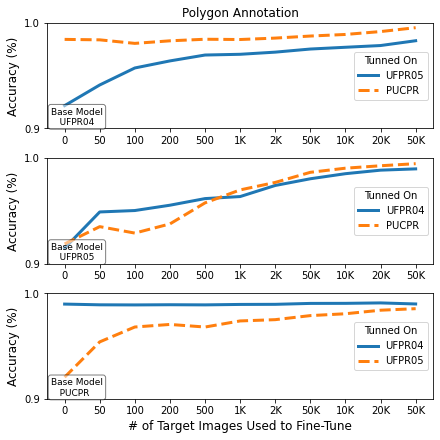

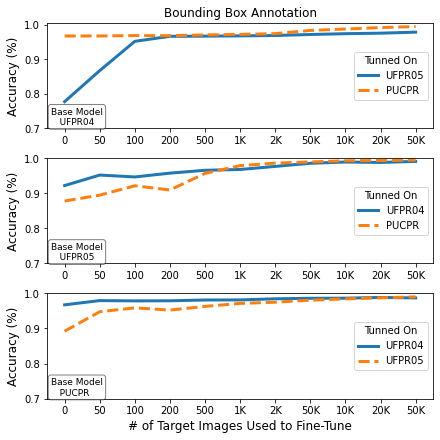

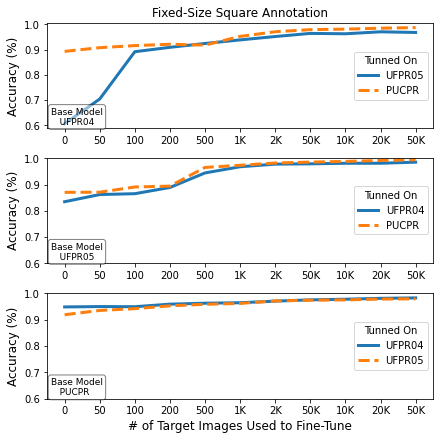

In [ ]:
batch = ['0','50','100','200','500','1000','2000','5000','10000','20000','50000']
batch_names = ['0','50','100','200','500','1K','2K','50K','10K','20K','50K']
ann_titles = ['Polygon','Bounding Box','Fixed-Size Square']



result_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_without-tl-without-aug.dict'
a_file = open(result_path,'rb')
general_rates = pickle.load(a_file)
a_file.close()

for ANN_TYPE,ANN_NAME in zip(['Poly','Bbox','Centroid'],ann_titles):
#for ANN_TYPE,ANN_NAME in zip(['Poly'],['Polygon']):
  fig, ax = plt.subplots(3, 1, figsize=(6,6),constrained_layout=True)    
  
  #fig.suptitle('Cross-Domain Performance using ' + ANN_NAME + ' Annotation')
  pos_ax=0
  min_rate=0.9
  for PKLOT_TRAIN in TRAIN_PKLOTS:
    acc_dict = {}
    result_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/results_dict_' + PKLOT_TRAIN + '.dict'
    a_file = open(result_path,'rb')
    acc_dict = pickle.load(a_file)
    a_file.close()

    lines = []          
    dashes = []    
    labels = []
    
    linestyles=['solid','dashed']
    
    for PKLOT_TARGET in TARGET_PKLOTS:
      if PKLOT_TARGET == PKLOT_TRAIN:          
          continue

   
      linestyle = linestyles.pop(0)
      
      acc_plotList = []
      fgt_plotList = []
      
      acc_rate = general_rates[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['acc']
      acc_plotList.append(acc_rate)
      fgt_plotList.append(0.0) #Nao tem perda no original pois nao houve finetunning
      for n_imgs in batch[1:-2]:        
        acc_rate = 0
        for n_round in range(1,11):          
          n_round = str(n_round)
          acc_rate += acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][n_imgs][n_round]['acc']

         
        acc_plotList.append(acc_rate/10.)

      acc_rate = acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['20000']['1']['acc']      
      acc_plotList.append(acc_rate)

      
      acc_rate = acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['50000']['1']['acc']
      acc_plotList.append(acc_rate)
      p, = ax[pos_ax].plot(acc_plotList, label=PKLOT_TARGET,linewidth=3,linestyle=linestyle)        
      lines.append(p)
      labels.append(PKLOT_TARGET)       
      
      if min(acc_plotList) < min_rate:
        min_rate = min(acc_plotList)
    
    ax[0].set_title(ANN_NAME + ' Annotation' )
    ax[pos_ax].set_xticks([])
    ax[pos_ax].set_xticks(np.arange(0,len(batch_names)))    
    ax[pos_ax].set_xticklabels(batch_names)
    
    
    if min_rate >= 0.9: min_rate = 0.9
    elif min_rate >= 0.8: min_rate = 0.8
    elif min_rate >= 0.7: min_rate = 0.7
    elif min_rate >= 0.6: min_rate = 0.6
    
    ax[pos_ax].set_yticks(np.arange(min_rate,1.02,0.1))
    
    textstr = 'Base Model\n   ' + PKLOT_TRAIN
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    # place a text box in upper left in axes coords
    ax[pos_ax].text(0.01, 0.2, textstr, transform=ax[pos_ax].transAxes, fontsize=9, verticalalignment='top', bbox=props)

    ax[pos_ax].set_ylabel('Accuracy (%)',fontsize='large')
    ax[-1].set_xlabel('# of Target Images Used to Fine-Tune',fontsize='large')
    ax[pos_ax].legend(loc=5,title='Tunned On') #4 = lower right
    

    fig.show()   
    path = 'res-finetunning-' + ANN_NAME  + '.png'
    plt.savefig(path)
    pos_ax+=1

 
  



In [ ]:
!rm *.zip
!zip ft-images.zip *.png

rm: cannot remove '*.zip': No such file or directory
  adding: res-acc-catatastrophic-forgetting-Bounding Box.png (deflated 5%)
  adding: res-acc-catatastrophic-forgetting-Fixed-Size Square.png (deflated 5%)
  adding: res-acc-catatastrophic-forgetting-Polygon.png (deflated 5%)
  adding: res-finetunning-Bounding Box.png (deflated 6%)
  adding: res-finetunning-Fixed-Size Square.png (deflated 6%)
  adding: res-finetunning-Polygon.png (deflated 5%)


## Plot Catastropic

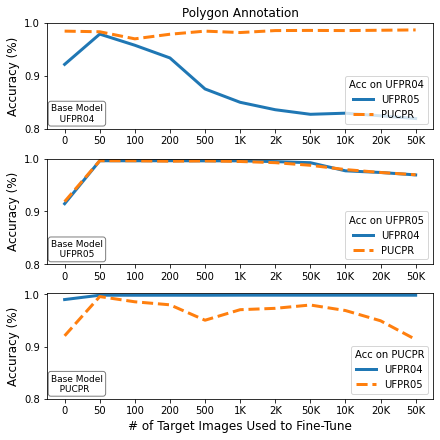

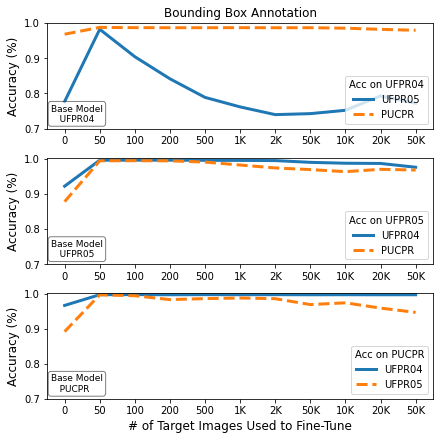

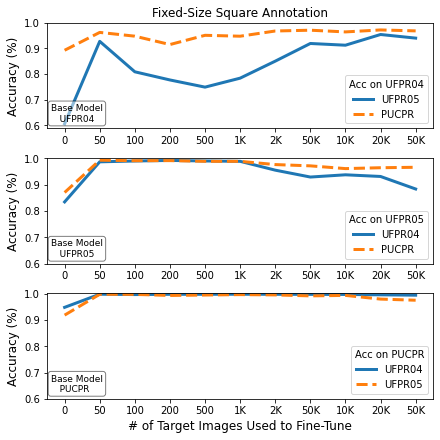

In [ ]:
batch = ['0','50','100','200','500','1000','2000','5000','10000','20000','50000']
batch_names = ['0','50','100','200','500','1K','2K','50K','10K','20K','50K']
ann_titles = ['Polygon','Bounding Box','Fixed-Size Square']



result_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/results_dict_without-tl-without-aug.dict'
a_file = open(result_path,'rb')
general_rates = pickle.load(a_file)
a_file.close()

for ANN_TYPE,ANN_NAME in zip(['Poly','Bbox','Centroid'],ann_titles):
#for ANN_TYPE,ANN_NAME in zip(['Centroid'],['Fixed-Size Square']):
  fig, ax = plt.subplots(3, 1, figsize=(6,6),constrained_layout=True)    
  
  #fig.suptitle('Cross-Domain Accuracy (%) using ' + ANN_NAME + ' Annotation')
  pos_ax=0
  min_rate=0.9
  for PKLOT_TRAIN in TRAIN_PKLOTS:
    acc_dict = {}
    result_path = '/gdrive/MyDrive/Datasets/PKLOT-WEIGHTS/FINETUNNED/results_dict_' + PKLOT_TRAIN + '.dict'
    a_file = open(result_path,'rb')
    acc_dict = pickle.load(a_file)
    a_file.close()

    lines = []          
    dashes = []    
    labels = []
    
    linestyles=['solid','dashed']
    
    for PKLOT_TARGET in TARGET_PKLOTS:
      if PKLOT_TARGET == PKLOT_TRAIN:          
          continue

   
      linestyle = linestyles.pop(0)
      
      acc_rate = general_rates[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['acc']

      fgt_plotList = [acc_rate]
      for n_imgs in batch[1:-2]:  
        #Compute Catastrophic
        fgt_acc =acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE][n_imgs]['CATASTROPHIC']['acc']
        fgt_plotList.append(fgt_acc)
      
      fgt_acc =acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['20000']['CATASTROPHIC']['acc']
      fgt_plotList.append(fgt_acc)

      fgt_acc =acc_dict[PKLOT_TRAIN][PKLOT_TARGET][ANN_TYPE]['50000']['CATASTROPHIC']['acc']
      fgt_plotList.append(fgt_acc)
      d, = ax[pos_ax].plot(fgt_plotList, label=PKLOT_TARGET ,linewidth=3,linestyle=linestyle)  
      if min(fgt_plotList) < min_rate:
        min_rate = min(fgt_plotList)
      

    # Create a legend for the first line.
    
    #lines_legend = ax[pos_ax].legend(lines,labels, loc='upper right',bbox_to_anchor=(0.9, 0.8, 0.05, 0.05))    
    # Add the legend manually to the Axes.    
    #ax[pos_ax].add_artist(lines_legend)

    
    #dashed_legend = ax[pos_ax].legend(dashes,labels, loc='lower right', bbox_to_anchor=(0.2, 0.2, 0.05, 0.05),title = 'Loss on Source')

    #ax[pos_ax].add_artist(dashed_legend)
    

    ax[0].set_title(ANN_NAME + ' Annotation' )
    ax[pos_ax].set_xticks([])
    ax[pos_ax].set_xticks(np.arange(0,len(batch_names)))    
    ax[pos_ax].set_xticklabels(batch_names)
    
    #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
   
    
    if min_rate >= 0.9: min_rate = 0.9
    elif min_rate >= 0.8: min_rate = 0.8
    elif min_rate >= 0.7: min_rate = 0.7
    elif min_rate >= 0.6: min_rate = 0.6
    
    ax[pos_ax].set_yticks(np.arange(min_rate,1.03,0.1))
    
    textstr = 'Base Model\n   ' + PKLOT_TRAIN
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    # place a text box in upper left in axes coords
    ax[pos_ax].text(0.01, 0.05, textstr, transform=ax[pos_ax].transAxes, fontsize=9, verticalalignment='bottom', bbox=props)

    ax[pos_ax].set_ylabel('Accuracy (%)',fontsize='large')
    ax[-1].set_xlabel('# of Target Images Used to Fine-Tune',fontsize='large')
    ax[pos_ax].legend(loc='lower right',title='Acc on ' + PKLOT_TRAIN) #4 = lower right
    

    fig.show()   
    path = 'res-acc-catatastrophic-forgetting-' + ANN_NAME  + '.png'
    plt.savefig(path)
    pos_ax+=1

 
  

